In [2]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


Performing feature selection...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Selected 11 features from 21 original features.
Selected features: flow_time, header_size, overall_rate, src_rate, urg_packets, rst_packets, max_value, value_covariance, protocol_tcp, protocol_udp, protocol_icmp

Training XGBoost model...

Training Stacking Classifier...


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



===== XGBoost Evaluation =====
Training Accuracy: 0.9023
Test Accuracy: 0.8963

Classification Report:
               precision    recall  f1-score   support

BenignTraffic       0.82      0.94      0.87      4397
         DDoS       0.90      0.97      0.93    119580
          DoS       0.84      0.61      0.71     31699
         MITM       0.85      0.67      0.75      1263
        Mirai       1.00      0.99      0.99     10255
        Recon       0.72      0.62      0.67      1286

     accuracy                           0.90    168480
    macro avg       0.86      0.80      0.82    168480
 weighted avg       0.89      0.90      0.89    168480



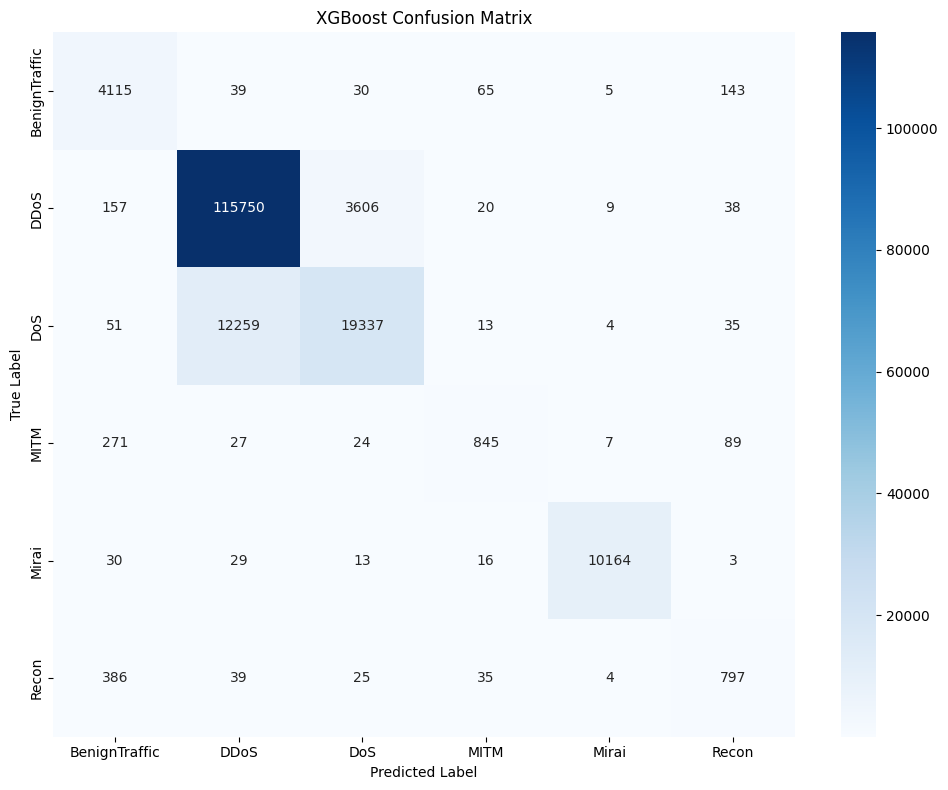


===== Stacking Classifier Evaluation =====
Training Accuracy: 0.9012
Test Accuracy: 0.8956

Classification Report:
               precision    recall  f1-score   support

BenignTraffic       0.83      0.93      0.87      4397
         DDoS       0.91      0.96      0.93    119580
          DoS       0.82      0.63      0.71     31699
         MITM       0.84      0.67      0.75      1263
        Mirai       1.00      0.99      0.99     10255
        Recon       0.71      0.64      0.67      1286

     accuracy                           0.90    168480
    macro avg       0.85      0.80      0.82    168480
 weighted avg       0.89      0.90      0.89    168480



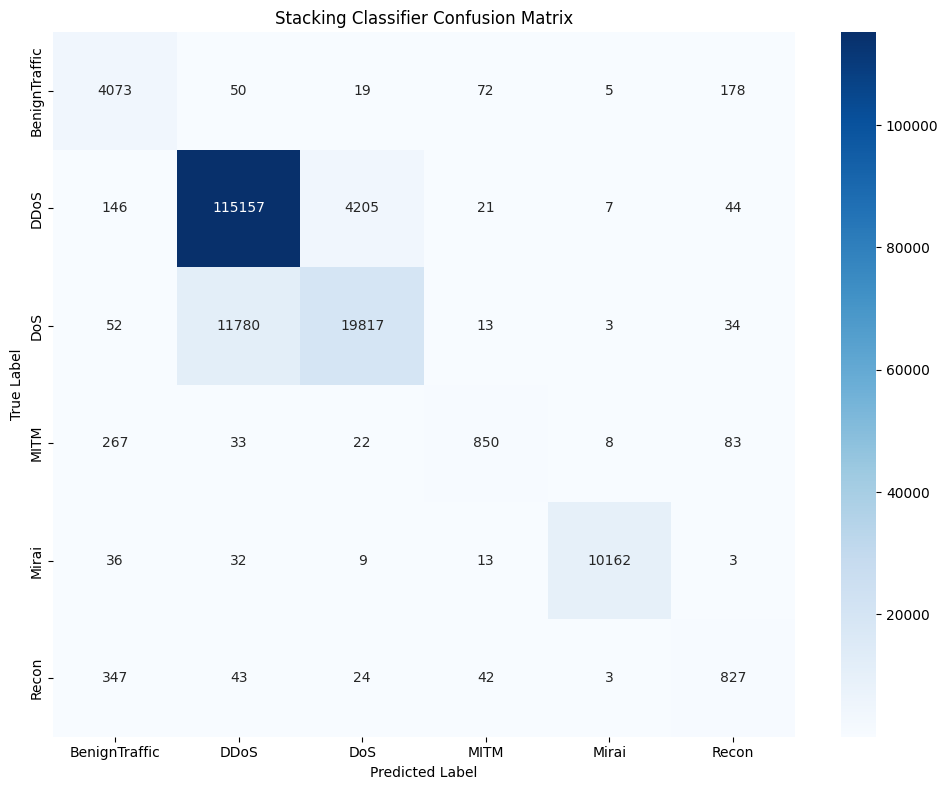

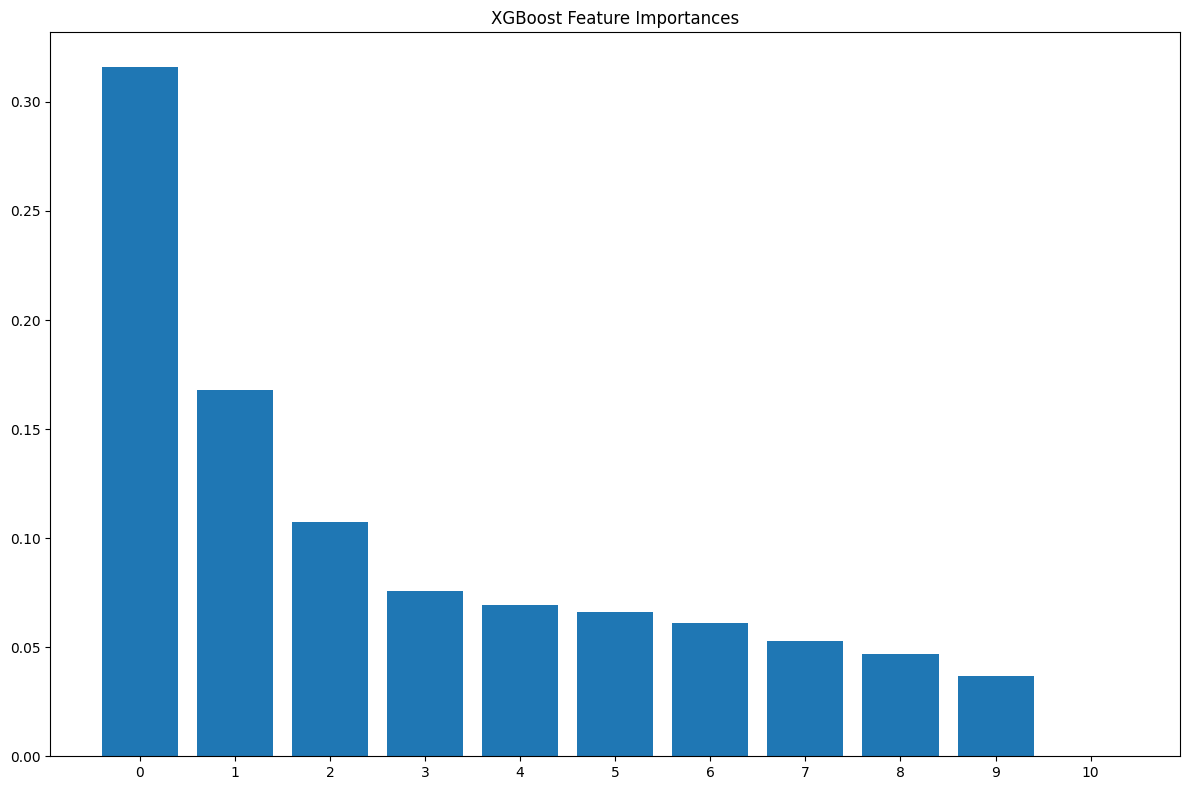

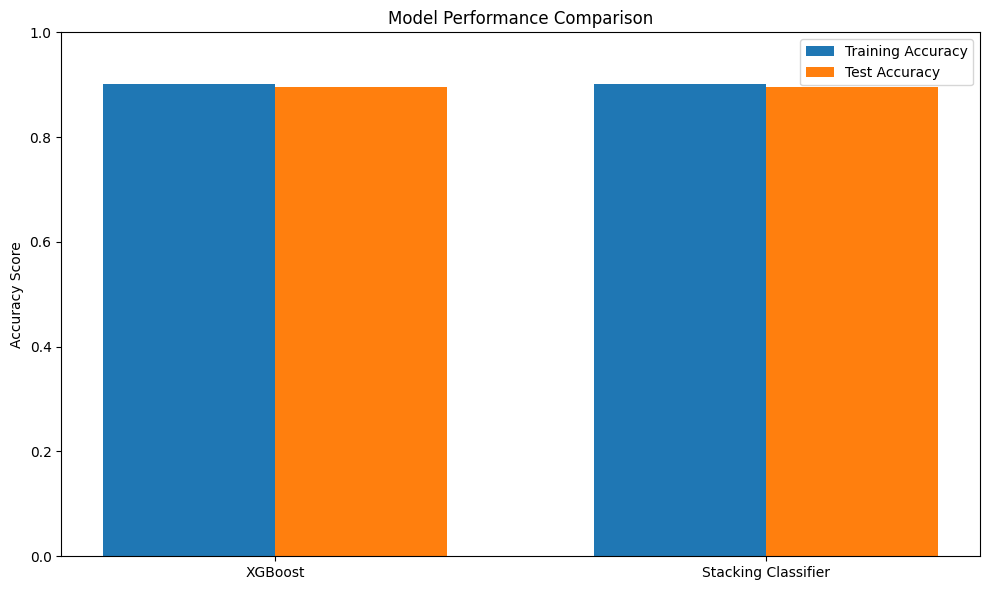


Saving models...
✅ Saved xgb_model.joblib and stacking_model.joblib



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Download complete


In [25]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.ensemble import BalancedRandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import dump
from google.colab import files

# Columns to transform
num_cols = [
    "flow_time", "header_size", "packet_duration", "overall_rate",
    "src_rate", "dst_rate", "fin_packets", "urg_packets",
    "rst_packets", "max_value", "value_covariance"
]

# Load & clean data
def load_and_clean(path):
    df = pd.read_csv(path)
    df = df.drop_duplicates()
    df = df.sample(frac=1, random_state=42).reset_index(drop=True)
    for col in num_cols:
        lo, hi = np.percentile(df[col], [1, 99])
        df[col] = df[col].clip(lo, hi)
        df[col] = np.log1p(df[col])
    return df

# Preprocess: encode and scale
def preprocess(df):
    X = df.drop(columns=["label"])
    y = df["label"].values
    le = LabelEncoder()
    y = le.fit_transform(y)
    class_names = le.classes_

    scaler = StandardScaler()
    X[num_cols] = scaler.fit_transform(X[num_cols])
    return X, y, class_names

# Base tree models factory - needed for stacking
def get_tree_models():
    return [
        ("dt", DecisionTreeClassifier(max_depth=10, class_weight="balanced", random_state=42)),
        ("et", ExtraTreesClassifier(n_estimators=100, max_depth=10, n_jobs=-1, random_state=42)),
        ("rf", RandomForestClassifier(n_estimators=100, max_depth=10, class_weight="balanced", n_jobs=-1, random_state=42)),
        ("brf", BalancedRandomForestClassifier(n_estimators=100, max_depth=10, n_jobs=-1, random_state=42))
    ]

# Evaluate and visualize model performance
def evaluate_model(model, X_train, X_test, y_train, y_test, class_names, model_name):
    # Calculate accuracies
    train_acc = accuracy_score(y_train, model.predict(X_train))
    test_acc = accuracy_score(y_test, model.predict(X_test))

    print(f"\n===== {model_name} Evaluation =====")
    print(f"Training Accuracy: {train_acc:.4f}")
    print(f"Test Accuracy: {test_acc:.4f}")

    # Generate classification report
    y_pred = model.predict(X_test)
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=class_names))

    # Generate confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'{model_name} Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

    return train_acc, test_acc

# Main execution code
path = '/content/drive/My Drive/ML project/phase2_students_before_cleaning.csv'
df = load_and_clean(path)
X, y, class_names = preprocess(df)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Feature selection
print("Performing feature selection...")
selector = ExtraTreesClassifier(n_estimators=50, max_depth=10, random_state=42, n_jobs=-1)
selector.fit(X_train, y_train)
sfm = SelectFromModel(selector, prefit=True, threshold="median")
X_train_selected = sfm.transform(X_train)
X_test_selected = sfm.transform(X_test)
print(f"Selected {X_train_selected.shape[1]} features from {X.shape[1]} original features.")

# Identify selected features (optional)
selected_indices = sfm.get_support()
selected_features = X.columns[selected_indices]
print(f"Selected features: {', '.join(selected_features)}")

# Create and train XGBoost model
print("\nTraining XGBoost model...")
xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    eval_metric="mlogloss",
    n_jobs=-1,
    random_state=42
)
xgb_model.fit(X_train_selected, y_train)

# Create base estimators for stacking
print("\nTraining Stacking Classifier...")
tree_models = get_tree_models()
xgb_tuple = ("xgb", XGBClassifier(
    n_estimators=100,
    max_depth=6,
    eval_metric="mlogloss",
    n_jobs=-1,
    random_state=42
))
base_estimators = tree_models + [xgb_tuple]

# Create and train Stacking model
stack_clf = StackingClassifier(
    estimators=base_estimators,
    final_estimator=LogisticRegression(solver="lbfgs", max_iter=200, random_state=42),
    stack_method="predict_proba",
    n_jobs=-1
)
stack_clf.fit(X_train_selected, y_train)

# Evaluate models
xgb_metrics = evaluate_model(xgb_model, X_train_selected, X_test_selected,
                            y_train, y_test, class_names, "XGBoost")
stack_metrics = evaluate_model(stack_clf, X_train_selected, X_test_selected,
                              y_train, y_test, class_names, "Stacking Classifier")

# Feature importance for XGBoost (optional)
if hasattr(xgb_model, "feature_importances_"):
    importances = xgb_model.feature_importances_
    indices = np.argsort(importances)[::-1]

    plt.figure(figsize=(12, 8))
    plt.title('XGBoost Feature Importances')
    plt.bar(range(X_train_selected.shape[1]), importances[indices], align='center')
    plt.xticks(range(X_train_selected.shape[1]), range(X_train_selected.shape[1]))
    plt.tight_layout()
    plt.show()

# Compare model performances
models = ["XGBoost", "Stacking Classifier"]
train_accs = [xgb_metrics[0], stack_metrics[0]]
test_accs = [xgb_metrics[1], stack_metrics[1]]

plt.figure(figsize=(10, 6))
x = np.arange(len(models))
width = 0.35

plt.bar(x - width/2, train_accs, width, label='Training Accuracy')
plt.bar(x + width/2, test_accs, width, label='Test Accuracy')

plt.ylabel('Accuracy Score')
plt.title('Model Performance Comparison')
plt.xticks(x, models)
plt.ylim(0, 1.0)
plt.legend()
plt.tight_layout()
plt.show()

# Save models
print("\nSaving models...")
dump(xgb_model, 'xgb_model.joblib')
dump(stack_clf, 'stacking_model.joblib')
print("✅ Saved xgb_model.joblib and stacking_model.joblib")

# Download models to local machine
print("\nDownloading models to your computer...")
files.download('xgb_model.joblib')
files.download('stacking_model.joblib')
print("✅ Download complete")

In [32]:
from joblib import dump

# …after you fit your scaler and selector…

# 1) Save the scaler you used on the training data
dump(scaler, 'scaler.joblib')
print("✅ scaler.joblib written")

# 2) Save the feature-selector you used
dump(sfm, 'selector.joblib')
print("✅ selector.joblib written")

# (you can also dump your label encoder if you need it)
# dump(le, 'label_encoder.joblib')
# print("✅ label_encoder.joblib written")


✅ scaler.joblib written
✅ selector.joblib written


In [34]:
import pandas as pd
import numpy as np
from joblib import load

# ----------------------------------------------------------------------------
# 1) Define data cleaning used during training
# ----------------------------------------------------------------------------
num_cols = [
    "flow_time", "header_size", "packet_duration", "overall_rate",
    "src_rate", "dst_rate", "fin_packets", "urg_packets",
    "rst_packets", "max_value", "value_covariance"
]

def load_and_clean(path):
    df = pd.read_csv(path)
    # Clip outliers at 1st and 99th percentiles
    for col in num_cols:
        lo, hi = np.percentile(df[col], [1, 99])
        df[col] = df[col].clip(lo, hi)
        df[col] = np.log1p(df[col])
    return df

# ----------------------------------------------------------------------------
# 2) Load trained artifacts
# ----------------------------------------------------------------------------
xgb_model    = load('xgb_model.joblib')
stack_model  = load('stacking_model.joblib')
scaler       = load('scaler.joblib')
selector     = load('selector.joblib')

# ----------------------------------------------------------------------------
# 3) Process test data
# ----------------------------------------------------------------------------
test_path = '/content/test.csv'
df_test   = load_and_clean(test_path)

# Retain Ids if present
if 'Id' in df_test.columns:
    ids = df_test['Id']
    df_test = df_test.drop(columns=['Id'])
else:
    ids = pd.Series(np.arange(len(df_test)), name='Id')

# Scale numerical features
df_test[num_cols] = scaler.transform(df_test[num_cols])

# Select features
X_test_selected = selector.transform(df_test)

# ----------------------------------------------------------------------------
# 4) Generate predictions for each model
# ----------------------------------------------------------------------------
# 4a) XGBoost
preds_xgb = xgb_model.predict(X_test_selected)

# 4b) Stacking
preds_stack = stack_model.predict(X_test_selected)

# 4c) Optional ensemble (averaging probabilities)
preds_ensemble = None
try:
    probs_xgb      = xgb_model.predict_proba(X_test_selected)
    probs_stack    = stack_model.predict_proba(X_test_selected)
    avg_probs      = (probs_xgb + probs_stack) / 2
    preds_ensemble = np.argmax(avg_probs, axis=1)
except Exception:
    pass

# Map numeric codes back to labels
def to_labels(arr):
    num2label = {0: 'BenignTraffic', 1: 'DDoS', 2: 'DoS', 3: 'MITM', 4: 'Mirai', 5: 'Recon'}
    return [num2label[i] for i in arr]

# ----------------------------------------------------------------------------
# 5) Save submissions for each model
# ----------------------------------------------------------------------------
# XGBoost submission
sub_xgb = pd.DataFrame({'Id': ids, 'Target': to_labels(preds_xgb)})
out_xgb = 'xgb_submission.csv'
sub_xgb.to_csv(out_xgb, index=False)
print(f"Saved {out_xgb} with {len(sub_xgb)} rows")

# Stacking submission
sub_stack = pd.DataFrame({'Id': ids, 'Target': to_labels(preds_stack)})
out_stack = 'stacking_submission.csv'
sub_stack.to_csv(out_stack, index=False)
print(f"Saved {out_stack} with {len(sub_stack)} rows")

# Ensemble submission (if available)
if preds_ensemble is not None:
    sub_ens = pd.DataFrame({'Id': ids, 'Target': to_labels(preds_ensemble)})
    out_ens = 'ensemble_submission.csv'
    sub_ens.to_csv(out_ens, index=False)
    print(f"Saved {out_ens} with {len(sub_ens)} rows")


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Saved xgb_submission.csv with 104287 rows
Saved stacking_submission.csv with 104287 rows
Saved ensemble_submission.csv with 104287 rows


In [14]:
from joblib import dump

dump(xgb_model, 'xgb_model.joblib')
dump(stack_clf, 'stacking_model.joblib')

print("✅ Saved xgb_model.joblib and stacking_model.joblib")


NameError: name 'xgb_model' is not defined

In [ ]:
import pandas as pd
import numpy as np
from joblib import load
from sklearn.preprocessing import StandardScaler

# 1) Load Kaggle test data
test_df = pd.read_csv('/content/test.csv')

# 2) Your numeric columns (used in preprocessing)
num_cols = [
    "flow_time", "header_size", "packet_duration", "overall_rate",
    "src_rate", "dst_rate", "fin_packets", "urg_packets",
    "rst_packets", "max_value", "value_covariance"
]

# 3) Your label mapping (numbers back to categories)
num2label = {
    0: 'BenignTraffic',
    1: 'DDoS',
    2: 'DoS',
    3: 'MITM',
    4: 'Mirai',
    5: 'Recon'
}

# 4) Load models
model_files = {
    'xgb':      '/content/xgb_model.joblib',
    'stacking': '/content/stacking_model.joblib'
}

# 5) For processed version: rebuild scaler
def process_test_data(df):
    df_copy = df.copy()

    # Winsorize + log1p
    for col in num_cols:
        lo, hi = np.percentile(df_copy[col], [1, 99])
        df_copy[col] = np.clip(df_copy[col], lo, hi)
        df_copy[col] = np.log1p(df_copy[col])

    # Scale
    scaler = StandardScaler()
    df_copy[num_cols] = scaler.fit_transform(df_copy[num_cols])

    return df_copy

# 6) Make predictions and save
for processing in ['processed', 'raw']:
    if processing == 'processed':
        X_test = process_test_data(test_df)
    else:
        X_test = test_df.copy()

    feature_cols = [c for c in X_test.columns if c != 'Id']
    X_test = X_test[feature_cols]

    for model_name, model_path in model_files.items():
        model = load(model_path)

        preds_num = model.predict(X_test)
        preds_str = [num2label[i] for i in preds_num]

        sub = pd.DataFrame({
            'Id': test_df['Id'],  # always original Ids
            'Target': preds_str
        })

        out_fname = f'/content/{model_name}_{processing}_submission.csv'
        sub.to_csv(out_fname, index=False)
        print(f"Wrote {out_fname}: {len(sub)} rows')


In [ ]:
from google.colab import files
files.download('/content/xgb_processed_submission.csv')
files.download('/content/xgb_raw_submission.csv')
files.download('/content/stacking_processed_submission.csv')
files.download('/content/stacking_raw_submission.csv')

In [4]:
from joblib import load, dump

# 1. Load the combined file
best_preds = load('best_preds.joblib')

# 2. Extract each prediction array
xgb_preds      = best_preds['xgb']
stacking_preds = best_preds['stacking']

# 3. Save each to its own file
dump(xgb_preds,      'xgb_preds.joblib')
dump(stacking_preds, 'stacking_preds.joblib')

print("Written xgb_preds.joblib and stacking_preds.joblib")


Written xgb_preds.joblib and stacking_preds.joblib


In [5]:
import pandas as pd
from joblib import load

# 1. Load your test set (must contain an 'Id' column)
test_df = pd.read_csv('/content/test.csv')

# 2. Define the numeric→string mapping (invert of your label encoder)
num2label = {
    0: 'BenignTraffic',
    1: 'DDoS',
    2: 'DoS',
    3: 'MITM',
    4: 'Mirai',
    5: 'Recon'
}

# 3. List all your .joblib prediction files
prediction_files = {
    'xgb':      'xgb_preds.joblib',
    'stacking': 'stacking_preds.joblib'
    # add more here if you have e.g. 'soft_voting': 'soft_preds.joblib', etc.
}

# 4. For each, load the numeric preds, map → strings, and save a submission CSV
for model_name, joblib_path in prediction_files.items():
    # load the array of numeric codes
    preds_num = load(joblib_path)

    # map to strings
    preds_str = [ num2label[i] for i in preds_num ]

    # build submission DataFrame
    sub = pd.DataFrame({
        'Id':     test_df['Id'],
        'Target': preds_str
    })

    # save
    filename = f'{model_name}_submission.csv'
    sub.to_csv(filename, index=False)
    print(f'Wrote {filename} ({len(sub)} rows)')


ValueError: array length 168480 does not match index length 43614